*Accompanying code examples of the book "Introduction to Artificial Neural Networks and Deep Learning: A Practical Guide with Applications in Python" by [Sebastian Raschka](https://sebastianraschka.com). All code examples are released under the [MIT license](https://github.com/rasbt/deep-learning-book/blob/master/LICENSE). If you find this content useful, please consider supporting the work by buying a [copy of the book](https://leanpub.com/ann-and-deeplearning).*
  
Other code examples and content are available on [GitHub](https://github.com/rasbt/deep-learning-book). The PDF and ebook versions of the book are available through [Leanpub](https://leanpub.com/ann-and-deeplearning).

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch

Sebastian Raschka 

CPython 3.6.7
IPython 7.1.1

torch 0.4.1


- Runs on CPU or GPU (if available)

# Model Zoo -- Plotting Live Training Performance in Jupyter Notebooks via Matplotlib

There are more sophisticated ways to plot the performance of a model during training than using matplotlib. However, sometimes, we just want to keep it simple, and this notebook shows how we can create a simple plotting function with matplotlib that updates every epoch. 


A simple example of this is shown below (of course, we could extend it to show e.g., a grid of multiple plots):

<IPython.core.display.Javascript object>


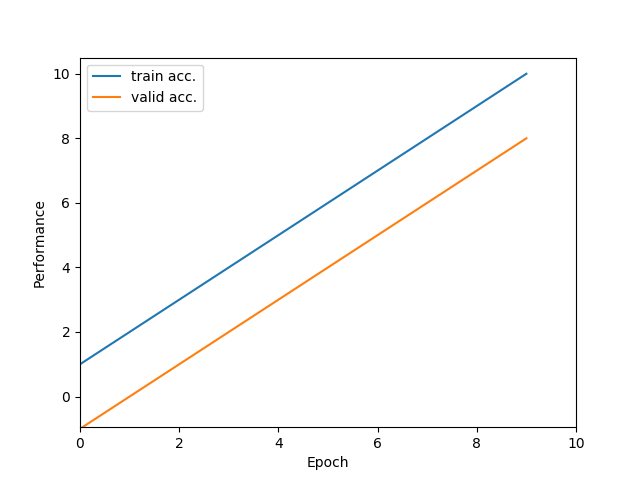

In [2]:
import numpy as np
from matplotlib import pyplot as plt

class LivePerformanceplot(object):

    def __init__(self, labels, xlim='auto', ylim='auto', xlabel='Epoch', ylabel='Performance'):

        
        self.xlim = xlim
        self.ylim = ylim
        fig, ax = plt.subplots(1, 1)
        self.ax = ax
        self.fig = fig
        
        self.labels = labels
        for label in self.labels:
            self.ax.plot([0], label=label)

        if not xlim == 'auto':
            self.ax.set_xlim(self.xlim)

        if not ylim == 'auto':
            self.ax.set_ylim(self.ylim)

        self.ax.set_xlabel(xlabel)
        self.ax.set_ylabel(ylabel)
        self.ax.legend()
        
        self.max = -np.inf
        self.min = np.inf
        self.num_iter = 0

    def update(self, data_dict):             
        self.num_iter += 1
        
        if self.xlim == 'auto':
            self.ax.set_xlim(0, self.num_iter)
        
        changed = False
        for i, label in enumerate(self.labels):
            
            line = self.ax.lines[i]
            line.set_xdata(data_dict[label][0])
            line.set_ydata(data_dict[label][1])
            
            recent_y_value = data_dict[label][1][-1]

            if self.ylim == 'auto':
                changed = False
                if recent_y_value > self.max:
                    self.max = recent_y_value
                    changed = True
                if recent_y_value < self.min:
                    self.min = recent_y_value
                    changed = True
                    
            if changed:  
                self.ax.set_ylim(self.min - self.min*0.05, self.max + self.max*0.05)

            self.fig.canvas.draw()


            
########## Testing
            
import time

%matplotlib notebook
plot = LivePerformanceplot(labels=['train acc.', 'valid acc.'])

x1 = []
y1 = []

x2 = []
y2 = []

for i in range(10):
    time.sleep(2)
    x1.append(i)
    y1.append(i+1)
    
    x2.append(i)
    y2.append(i-1)
    
    data_dict = {'train acc.': [x1, y1], 'valid acc.': [x2, y2]}
    plot.update(data_dict=data_dict)

## Imports

In [3]:
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

## Settings and Dataset

In [4]:
##########################
### SETTINGS
##########################

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyperparameters
random_seed = 1
learning_rate = 0.05
num_epochs = 10
batch_size = 128

# Architecture
num_classes = 10


##########################
### MNIST DATASET
##########################

# Note transforms.ToTensor() scales input images
# to 0-1 range
train_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='data', 
                              train=False, 
                              transform=transforms.ToTensor())


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


## Model

In [5]:
##########################
### MODEL
##########################


class ConvNet(torch.nn.Module):

    def __init__(self, num_classes):
        super(ConvNet, self).__init__()
        
        # calculate same padding:
        # (w - k + 2*p)/s + 1 = o
        # => p = (s(o-1) - w + k)/2
        
        # 28x28x1 => 28x28x4
        self.conv_1 = torch.nn.Conv2d(in_channels=1,
                                      out_channels=4,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      padding=1) # (1(28-1) - 28 + 3) / 2 = 1
        # 28x28x4 => 14x14x4
        self.pool_1 = torch.nn.MaxPool2d(kernel_size=(2, 2),
                                         stride=(2, 2),
                                         padding=0) # (2(14-1) - 28 + 2) = 0                                       
        # 14x14x4 => 14x14x8
        self.conv_2 = torch.nn.Conv2d(in_channels=4,
                                      out_channels=8,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      padding=1) # (1(14-1) - 14 + 3) / 2 = 1                 
        # 14x14x8 => 7x7x8                             
        self.pool_2 = torch.nn.MaxPool2d(kernel_size=(2, 2),
                                         stride=(2, 2),
                                         padding=0) # (2(7-1) - 14 + 2) = 0
        
        self.linear_1 = torch.nn.Linear(7*7*8, num_classes)

        
    def forward(self, x):
        out = self.conv_1(x)
        out = F.relu(out)
        out = self.pool_1(out)

        out = self.conv_2(out)
        out = F.relu(out)
        out = self.pool_2(out)
        
        logits = self.linear_1(out.view(-1, 7*7*8))
        probas = F.softmax(logits, dim=1)
        return logits, probas

    
torch.manual_seed(random_seed)
model = ConvNet(num_classes=num_classes)

model = model.to(device)
    

##########################
### COST AND OPTIMIZER
##########################

cost_fn = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

## Training

<IPython.core.display.Javascript object>


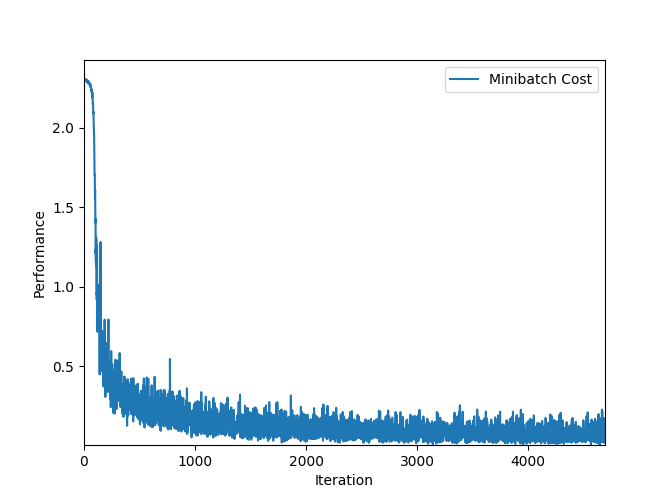

Epoch: 001/010 | Batch 000/469 | Cost: 2.3016
Epoch: 001/010 | Batch 050/469 | Cost: 2.2714
Epoch: 001/010 | Batch 100/469 | Cost: 1.6118
Epoch: 001/010 | Batch 150/469 | Cost: 0.8000
Epoch: 001/010 | Batch 200/469 | Cost: 0.5079
Epoch: 001/010 | Batch 250/469 | Cost: 0.3221
Epoch: 001/010 | Batch 300/469 | Cost: 0.2851
Epoch: 001/010 | Batch 350/469 | Cost: 0.3117
Epoch: 001/010 | Batch 400/469 | Cost: 0.2836
Epoch: 001/010 | Batch 450/469 | Cost: 0.3169
Epoch: 001/010 training accuracy: 92.72%
Epoch: 002/010 | Batch 000/469 | Cost: 0.2469
Epoch: 002/010 | Batch 050/469 | Cost: 0.2342
Epoch: 002/010 | Batch 100/469 | Cost: 0.2883
Epoch: 002/010 | Batch 150/469 | Cost: 0.2920
Epoch: 002/010 | Batch 200/469 | Cost: 0.1797
Epoch: 002/010 | Batch 250/469 | Cost: 0.2277
Epoch: 002/010 | Batch 300/469 | Cost: 0.1746
Epoch: 002/010 | Batch 350/469 | Cost: 0.2430
Epoch: 002/010 | Batch 400/469 | Cost: 0.1579
Epoch: 002/010 | Batch 450/469 | Cost: 0.1279
Epoch: 002/010 training accuracy: 95.07

In [6]:
def compute_accuracy(model, data_loader):
    correct_pred, num_examples = 0, 0
    for features, targets in data_loader:
        features = features.to(device)
        targets = targets.to(device)
        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100
    

    
minibatch_costs = []

%matplotlib notebook
plot = LivePerformanceplot(labels=['Minibatch Cost'],
                           xlabel='Iteration')


for epoch in range(num_epochs):

    model = model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(device)
        targets = targets.to(device)

        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = cost_fn(logits, targets)
        minibatch_costs.append(cost.detach().cpu().numpy())
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### UPDATE PLOT
        
        data_dict = {'Minibatch Cost': (range(len(minibatch_costs)), minibatch_costs)}
        plot.update(data_dict=data_dict)
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
    
    model = model.eval()
    print('Epoch: %03d/%03d training accuracy: %.2f%%' % (
          epoch+1, num_epochs, 
          compute_accuracy(model, train_loader)))

## Evaluation

In [7]:
print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader)))

Test accuracy: 97.76%
